In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81, cart_dampening = 10)
env.step_size = 0.02

In [3]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, d_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c d_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) - d_c*x_dot + u], [g*sp.sin(theta)]])

In [4]:
# find dx/dt = f(x, u) as specified above
f = sp.simplify(sp.simplify(mass_matrix.inv()@forcing_matrix))
f

⎡                              x_dot                               ⎤
⎢                                                                  ⎥
⎢                              θ_dot                               ⎥
⎢                                                                  ⎥
⎢                    g⋅mₚ⋅sin(2⋅θ)             2                   ⎥
⎢       -d_c⋅x_dot - ───────────── + l⋅mₚ⋅θ_dot ⋅sin(θ) + u        ⎥
⎢                          2                                       ⎥
⎢       ───────────────────────────────────────────────────        ⎥
⎢                                     2                            ⎥
⎢                         m_c + mₚ⋅sin (θ)                         ⎥
⎢                                                                  ⎥
⎢                      ⎛                       2           ⎞       ⎥
⎢g⋅(m_c + mₚ)⋅sin(θ) - ⎝-d_c⋅x_dot + l⋅mₚ⋅θ_dot ⋅sin(θ) + u⎠⋅cos(θ)⎥
⎢──────────────────────────────────────────────────────────────────⎥
⎢                         ⎛       

In [5]:
import numpy as np
from scipy.integrate import odeint
# substitute in model parameters, and create a function model
parameters = {m_c: env.m_c, m_p: env.m_p, l: env.l, g: env.g, d_c: env.c_d}
dx = sp.utilities.lambdify((x, theta, x_dot, theta_dot, u), f.subs(parameters))

# Simulate the model givan an input vector u
def sim(u, step_size, x0):
    t = np.linspace(0, (len(u)-1)*step_size, len(u))
    f = lambda y, t: dx(*y, u[min(int(t/step_size), len(u)-1)]).flatten()
    return odeint(f, x0.flatten(), t)

## Sequential approach
In the sequential approach solves directly for the cost given an input sequence 

In [21]:
# Define weight matrix Q and R
Q = np.matrix([[5, 0, 0, 0], [0, 10, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.matrix([[1]])


# Define prediction horizon and stepsize
horizon = 5        #Seconds
step_size = 0.10    #Seconds

# Calculate number of steps of step_size in horizon
num_states = int(horizon/step_size)

# Define cost function
def cost(z):
    x = sim(z.flatten(), step_size, env.x)
    cost = 0
    for xi in x:
        cost += xi.T@Q@xi
    for ui in z:
        cost += ui*R*ui
    return float(cost[0,0])

# define constraint
g_1 = lambda x: 20 - x
g_2 = lambda x: x + 20


In [7]:
import scipy.optimize
def sequential_nmpc(x_initial):
    res = scipy.optimize.minimize(fun = cost, 
                                  x0 = x_initial,
                                  method='SLSQP')
                                  #constraints=({'type': 'ineq', 'fun': g_1}, {'type': 'ineq', 'fun': g_2}))
    return res.x

In [22]:
z = np.zeros(num_states)
u = sequential_nmpc(z)
print(u)

C:\Users\andreabm\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[  2.88149306e+11  -4.24714645e+11   2.54898241e+11   1.92939284e+11
  -5.86879486e+10   3.17973163e+10   2.21053974e+11   1.73217618e+11
  -8.22137221e+10  -1.19549390e+11   1.52183209e+11  -8.17435053e+10
   1.75081011e+11   2.33201634e+11  -7.23415384e+09  -1.89279559e+11
   1.91374180e+10  -5.78324720e+10  -4.14208995e+11   1.24406551e+11
  -1.22252810e+11  -1.12280377e+11  -7.11314915e+10  -1.60840381e+11
  -2.31976213e+10  -8.90015241e+10  -6.70763697e+09   4.11422875e+10
   2.73759634e+10  -1.93547488e+11  -7.18442445e+10   8.88489353e+10
   1.74780873e+10   1.21368850e+10  -9.31261714e+10  -8.24295676e+10
  -8.84564854e+10  -6.89231885e+10  -4.13465188e+10  -1.17022259e+11
  -3.77486211e+10  -1.33785690e+11  -3.19358819e+10  -3.86021358e+08
  -8.09439372e+10  -3.84326539e+08  -2.96281739e+08  -1.99213631e+08
  -1.42905928e+08  -2.63463582e+04]


In [23]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Initial guess for mpc
z = np.zeros(num_states)

# Simulate the environment for n_steps and save states in X
#n_steps = 500
#X = np.zeros((n_steps, len(env.x)))
#state = env.init([0, 0.1, 0, 0])
#for step in range(n_steps):
#    X[step, :] = env.x
#    #Run MPC at every step_size time intervall
#    if step*env.step_size/step_size % 1 == 0:
#        print(step)
#        z = np.roll(z, -1) #New guess
#        z = sequential_nmpc(z)
#    state = env.step(z[0])

#u = np.zeros(500)
#
X = sim(u, 0.02, env.x)

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[i,0] - 0.2, -0.1]), 
                     line.set_data([X[i,0], X[i,0] + np.sin(X[i, 1])],[0, np.cos(X[i, 1])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

C:\Users\andreabm\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [224]:
HTML(anim.to_html5_video())

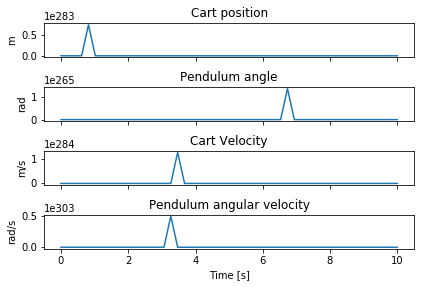

In [24]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

In [16]:
# Generates G matrix given quadratic penaly Q and R
def gen_g(q, r, n):
    nx = np.shape(q)[0]
    nu = np.shape(r)[0]
    upper = np.concatenate((np.kron(np.identity(n), q), np.zeros([nx * n, nu * n])), axis=1)
    lower = np.concatenate((np.zeros([nu * n, nx * n]), np.kron(np.identity(n), r)), axis=1)
    return np.concatenate((upper, lower), axis=0)


import numpy as np
from scipy.integrate import odeint

# Define prediction horizon, number of states, number of inputs, and stepsize
N = 10
nx = 4
nu = 1
h = 0.1

# Weight matrix Q and R
Q = np.matrix([[5, 0, 0, 0], [0, 10, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.matrix([[1]])


# Define initial conditions
x0 = np.array([env.x]).T

# Compute the optimization problem matrices
G = gen_g(Q, R, N)

# Define objectve functions and constraint functions
fun = lambda x: (x.T@G@x)[0,0]
g_1 = lambda x: 2 - np.abs(x[0:nx*N:nx])
g_2 = lambda x: 0.1 - np.abs(x[nx*(N-1) + 1])

# Define helper functions
jac = lambda x: np.array(G@x)

def h_1(z):
    u = np.reshape(z.flatten()[N*nx:], (N, nu))
    solution_times = np.linspace(0, (N-1)*h, N)
    f = lambda state, time: dx(*state, *u[min(int(time/h), N-1), :]).flatten()
    x = odeint(f, x0.flatten(), solution_times)
    return np.array(x.flatten() - z.flatten()[0:N*nx])

def obj(z):
    u = np.reshape(z.flatten(), (N, nu))
    solution_times = np.linspace(0, (N-1)*h, N)
    f = lambda state, time: dx(*state, *u[min(int(time/h), N-1), :]).flatten()
    x = odeint(f, x0.flatten(), solution_times)
    cost = 0
    for xi in x:
        cost += xi.T@Q@xi
    for ui in u:
        cost += ui.T@R@ui
    return cost[0,0], x

In [ ]:
3,05639514678399e-05
4,00461509085644e-05
4,69143975844585e-05
4,78645910534291e-05
4,36195201372790e-05
3,52092128778124e-05
2,30922368493561e-05
7,27170229494677e-06
-1,15990534141296e-05
-2,87221160723880e-05